In [27]:
import pandas as pd
import numpy as np
import sys
import tensorflow as tf
from sklearn.metrics import f1_score

sys.path.append('../../src')
from lstm.lstm_from_scratch import LSTMModel
from utils.data_preprocessing import TextPreprocessor
from lstm.model_training import create_keras_lstm

import warnings
warnings.filterwarnings("ignore")

In [28]:
train = pd.read_csv('../../datasets/train.csv', index_col='id')
valid = pd.read_csv('../../datasets/valid.csv', index_col='id')
test = pd.read_csv('../../datasets/test.csv', index_col='id')
train.head()

,text,label
id,,
219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
436,Ibu pernah bekerja di grab indonesia,neutral
394,Paling suka banget makan siang di sini ayam sa...,positive
592,Pelayanan bus DAMRI sangat baik,positive


In [29]:
test.head()

,text,label
id,,
411,"Dekat dengan hotel saya menginap, hanya ditemp...",positive
729,"Iya benar, dia sedang jaga warung.",neutral
373,Kangkungnya lumayan tapi kepiting saus padangn...,negative
262,Bertempat di braga city walk yang satu gedung ...,positive
177,Gianyar terima bantuan sosial 2018 sebesar rp ...,neutral


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 219 to 719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    500 non-null    object
 1   label   500 non-null    object
dtypes: object(2)
memory usage: 11.7+ KB


In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 411 to 768
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    400 non-null    object
 1   label   400 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


## Preprocessing

In [32]:
preprocessor = TextPreprocessor(vocab_size=10000, max_length=100)
processed_data = preprocessor.preprocess_dataset(train, valid, test, use_vectorizer=False)

train_seq = processed_data['train_sequences']
val_seq = processed_data['val_sequences']
test_seq = processed_data['test_sequences']
train_labels = processed_data['train_labels']
val_labels = processed_data['val_labels']
test_labels = processed_data['test_labels']

vocab_size = processed_data['vocab_size']
num_classes = processed_data['num_classes']

print(f"Vocab size: {vocab_size}")
print(f"Num classes: {num_classes}")
print(f"Sequence shape: {train_seq.shape}")
print(f"Labels distribution: {np.bincount(train_labels)}")

Vocab size: 2796
Num classes: 3
Sequence shape: (500, 100)
Labels distribution: [192 119 189]


## Modelling

In [33]:
configs = {
    # # Effect of number of layers (3 variations)
    'lstm_1layer': {'hidden_sizes': [64], 'bidirectional': False},
    'lstm_2layer': {'hidden_sizes': [64, 64], 'bidirectional': False},
    'lstm_3layer': {'hidden_sizes': [64, 64, 64], 'bidirectional': False},
    
    # Effect of number of cells (3 variations)
    'lstm_cells_32': {'hidden_sizes': [16, 16], 'bidirectional': False},
    'lstm_cells_64': {'hidden_sizes': [64, 64], 'bidirectional': False},
    'lstm_cells_128': {'hidden_sizes': [128, 128], 'bidirectional': False},
    
    # Effect of directionality (2 variations)
    'lstm_unidirectional': {'hidden_sizes': [64,64], 'bidirectional': False},
    'lstm_bidirectional': {'hidden_sizes': [64,64], 'bidirectional': True}
}

In [34]:
training_results = {}

for name, config in configs.items():
    print(f"\nTraining {name}...")
    
    model = create_keras_lstm(vocab_size, num_classes, config)
    
    history = model.fit(
        train_seq, train_labels,
        validation_data=(val_seq, val_labels),
        epochs=10, batch_size=32, verbose=1
    )
    
    y_pred = np.argmax(model.predict(test_seq), axis=1)
    macro_f1 = f1_score(test_labels, y_pred, average='macro')
    
    # Save
    model.save(f'../../models/{name}.keras')
    
    training_results[name] = {
        'config': config,
        'macro_f1': macro_f1,
        'history': history.history
    }
    
    print(f"✅ {name} - F1: {macro_f1:.4f}")


Training lstm_1layer...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3471 - loss: 1.0912 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3691 - loss: 1.0772 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3949 - loss: 1.0732 - val_accuracy: 0.3800 - val_loss: 1.0796
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3861 - loss: 1.0836 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3524 - loss: 1.0869 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3756 - loss: 1.0837 - val_accuracy: 0.3800 - val_loss: 1.0797
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3348 - loss: 1.0911 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3753 - loss: 1.0789 -

## Compare models

In [35]:
def compare_implementations(model_path, config, test_data):
    """Compare Keras vs from scratch"""
    test_X, test_y = test_data
    
    keras_model = tf.keras.models.load_model(model_path)
    
    # dummy evaluation to build metrics and avoid warnings
    keras_model.evaluate(test_X[:1], test_y[:1], verbose=0)
    
    scratch_model = LSTMModel(
        vocab_size=vocab_size,
        embedding_dim=128,
        hidden_sizes=config['hidden_sizes'],
        num_classes=num_classes,
        bidirectional=config['bidirectional']
    )
    
    scratch_model.load_keras_weights(model_path)
    
    keras_proba = keras_model.predict(test_X, verbose=0)
    scratch_proba = scratch_model.predict_proba(test_X)
    
    keras_pred = np.argmax(keras_proba, axis=1)
    scratch_pred = scratch_model.predict(test_X)
    
    # Calculate metrics
    keras_f1 = f1_score(test_y, keras_pred, average='macro')
    scratch_f1 = f1_score(test_y, scratch_pred, average='macro')
    
    max_diff = np.max(np.abs(keras_proba - scratch_proba))
    agreement = np.mean(keras_pred == scratch_pred)
    
    
    return {
        'keras_f1': keras_f1,
        'scratch_f1': scratch_f1,
        'max_diff': max_diff,
        'agreement': agreement
    }

In [36]:
test_data = (test_seq, test_labels)
comparison_results = {}

for name, config in configs.items():
    print(f"\nComparing {name}...")
    model_path = f'../../models/{name}.keras'
    
    result = compare_implementations(model_path, config, test_data)
    comparison_results[name] = result
    
    print(f"  Keras F1: {result['keras_f1']:.4f}")
    print(f"  Scratch F1: {result['scratch_f1']:.4f}")
    print(f"  Max diff: {result['max_diff']:.6f}")
    print(f"  Agreement: {result['agreement']:.4f}")


Comparing lstm_1layer...
Weights loaded from ../../models/lstm_1layer.keras
  Keras F1: 0.1827
  Scratch F1: 0.1827
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_2layer...
Weights loaded from ../../models/lstm_2layer.keras
  Keras F1: 0.1844
  Scratch F1: 0.1844
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_3layer...
Weights loaded from ../../models/lstm_3layer.keras
  Keras F1: 0.1827
  Scratch F1: 0.1827
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_cells_32...
Weights loaded from ../../models/lstm_cells_32.keras
  Keras F1: 0.1844
  Scratch F1: 0.1844
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_cells_64...
Weights loaded from ../../models/lstm_cells_64.keras
  Keras F1: 0.1827
  Scratch F1: 0.1827
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_cells_128...
Weights loaded from ../../models/lstm_cells_128.keras
  Keras F1: 0.1827
  Scratch F1: 0.1827
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_unidirectional...
Weig

## Analysis and Visualization

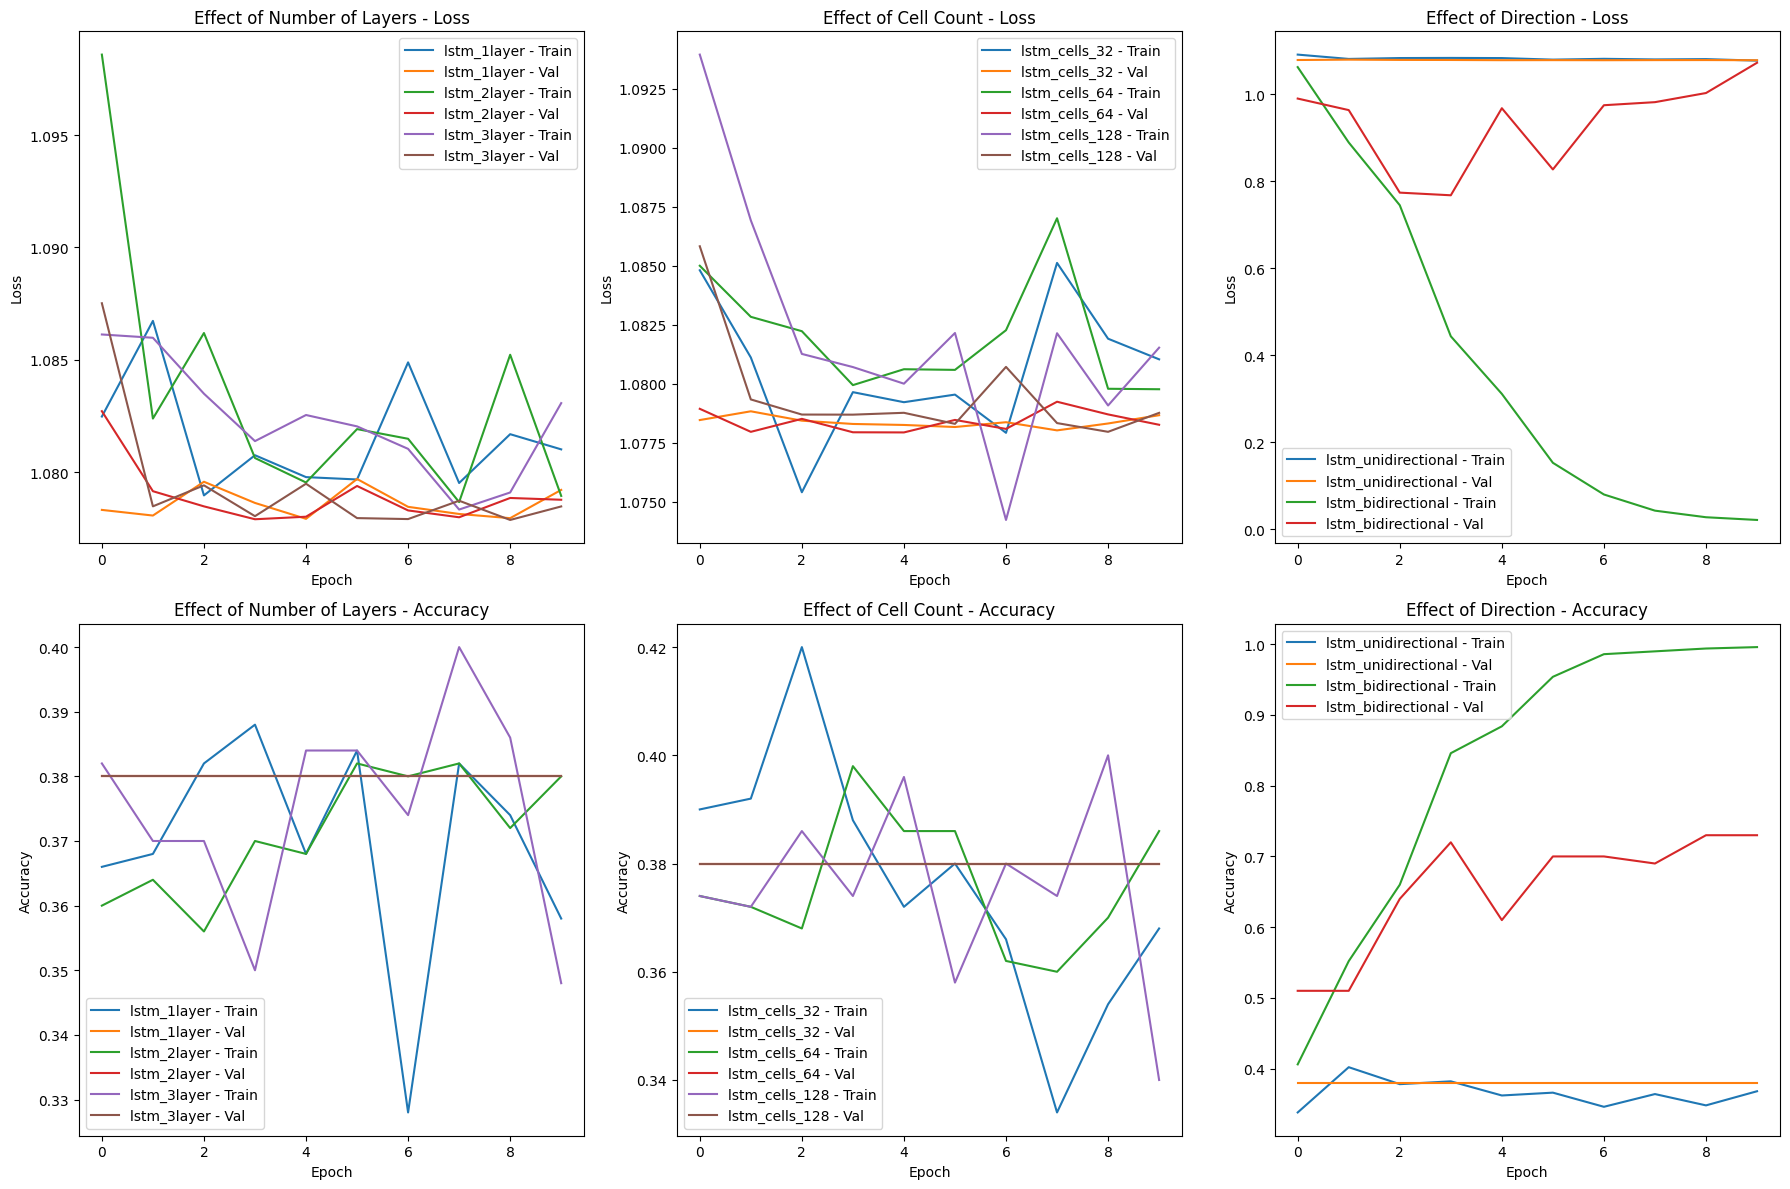

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(training_results):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    layer_configs = ['lstm_1layer', 'lstm_2layer', 'lstm_3layer']
    for i, config in enumerate(layer_configs):
        if config in training_results:
            history = training_results[config]['history']
            
            # Loss plot
            axes[0, 0].plot(history['loss'], label=f'{config} - Train')
            axes[0, 0].plot(history['val_loss'], label=f'{config} - Val')
            axes[0, 0].set_title('Effect of Number of Layers - Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].legend()
            
            # Accuracy plot
            axes[1, 0].plot(history['accuracy'], label=f'{config} - Train')
            axes[1, 0].plot(history['val_accuracy'], label=f'{config} - Val')
            axes[1, 0].set_title('Effect of Number of Layers - Accuracy')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Accuracy')
            axes[1, 0].legend()
    
    # Cell variations
    cell_configs = ['lstm_cells_32', 'lstm_cells_64', 'lstm_cells_128']
    for i, config in enumerate(cell_configs):
        if config in training_results:
            history = training_results[config]['history']
            
            # Loss plot
            axes[0, 1].plot(history['loss'], label=f'{config} - Train')
            axes[0, 1].plot(history['val_loss'], label=f'{config} - Val')
            axes[0, 1].set_title('Effect of Cell Count - Loss')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].legend()
            
            # Accuracy plot
            axes[1, 1].plot(history['accuracy'], label=f'{config} - Train')
            axes[1, 1].plot(history['val_accuracy'], label=f'{config} - Val')
            axes[1, 1].set_title('Effect of Cell Count - Accuracy')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Accuracy')
            axes[1, 1].legend()
    
    # Direction variations
    direction_configs = ['lstm_unidirectional', 'lstm_bidirectional']
    for i, config in enumerate(direction_configs):
        if config in training_results:
            history = training_results[config]['history']
            
            # Loss plot
            axes[0, 2].plot(history['loss'], label=f'{config} - Train')
            axes[0, 2].plot(history['val_loss'], label=f'{config} - Val')
            axes[0, 2].set_title('Effect of Direction - Loss')
            axes[0, 2].set_xlabel('Epoch')
            axes[0, 2].set_ylabel('Loss')
            axes[0, 2].legend()
            
            # Accuracy plot
            axes[1, 2].plot(history['accuracy'], label=f'{config} - Train')
            axes[1, 2].plot(history['val_accuracy'], label=f'{config} - Val')
            axes[1, 2].set_title('Effect of Direction - Accuracy')
            axes[1, 2].set_xlabel('Epoch')
            axes[1, 2].set_ylabel('Accuracy')
            axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(training_results)